# Introduction
This notebook compares the baseline model and SARIMAX (Seasonal Auto-Regressive Integrated Moving Average with eXogenous factors) model performance in an effort to predict total daily energy demand in Saskatchewan. Each model is trained and tested using a train-test split and cross-validation, respectively. The models’ performances are evaluated using metrics, such as Mean Squared Error (MSE), Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), Mean Absolute Percentage Error (MAPE), Median Absolute Percentage Error (MdAPE), and R-squared and the results are stored for each fold in the cross-validation. Finally, the performance of all models are compared, conclusions are drawn based on the evaluation metrics, and the best model is utilize for predictions using the testing dtaset. 

# Load Data
Forecasting daily natural gas consumption accurately is difficult because it is affected by various factors. The dataset is the historical daily natural gas demand in energy unit (TJ/d) and the weather data in Saskatchewan from November 1, 2013 to October 31, 2023. This dataset has be preprocessed and explored in the "cleaning_EDA.ipynb" notebook and is fit for model development. 

In [1]:
# Importing the necessary libraries 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Importing libraries for modules
import statsmodels.api as sm
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

import pickle
import warnings 
warnings.filterwarnings('ignore')

In [3]:
# Import the merged dataset (Natural Gas demand and Weather factors)
merged_df = pd.read_csv('../data/merged_data.csv')
merged_df.head()

,DATE,NG_DEMAND,LOWEST_REL_HUMIDITY,HIGHEST_REL_HUMIDITY,HEATING_DEGREE_DAYS,COOLING_DEGREE_DAYS,TOTAL_PRECIPITATION,LOWEST_TEMPERATURE,AVG_TEMPERATURE,HIGHEST_TEMPERATURE,DIRECTION_MAX_GUST,SPEED_MAX_GUST
0,2013-11-01,617,44.400000,80.333333,14.833333,0.0,0.140000,-2.933333,3.166667,9.206667,28.066667,40.600000
1,2013-11-02,630,34.133333,73.066667,16.293333,0.0,0.226667,-5.866667,1.706667,9.266667,8.400000,25.400000
2,2013-11-03,688,60.133333,81.600000,16.726667,0.0,5.806667,-2.166667,1.273333,4.706667,24.400000,55.000000
3,2013-11-04,815,66.466667,79.133333,23.540000,0.0,0.900000,-9.106667,-5.540000,-1.906667,31.466667,56.933333
4,2013-11-05,789,53.000000,71.666667,27.820000,0.0,0.040000,-14.966667,-9.820000,-4.633333,15.800000,21.600000


# Data Preparation for Modelling 

For this step, we are preparing the series for Cross-validation evaluation and the Train-test Split method.

- Train-test Split method: This method involves splitting the dataset into a training set and a testing set. The model is trained on the training set and then tested on the testing set to evaluate its performance.

- 
Cross-Validation: Cross-validation is a technique used to evaluate the performance of a machine learning model on unseen data. It involves dividing the available data into multiple folds or subsets, using one of these folds as a validation set, and training the model on the remaining folds

In [4]:
# Split the data into learning set from 2013-11-01 to 2022-04-31, and using 2022-05-01 to 2023-10-31 as testing set
learning_data_df = merged_df[merged_df['DATE'] < '2022-05-01'] # train/validation set
testing_data_df = merged_df[merged_df['DATE'] >= '2022-05-01'] # testing set

# Print the shape of the train-test split
print(learning_data_df.shape)
print(testing_data_df.shape)

(3103, 12)
(549, 12)


# Model Building
In this project, the recommended models to be utilized are Prophet, LightGBM, SARIMAX, LSTM, Hybrid Prophet-LGBM, and Hybrid Prophet-LSTM.

## 1. Baseline Model
In every modeling process, there needs to be a baseline model whose results can be used to assess our primary ones. In our case, we chose to use a Linear Regression model because of its simplicity and efficiency.

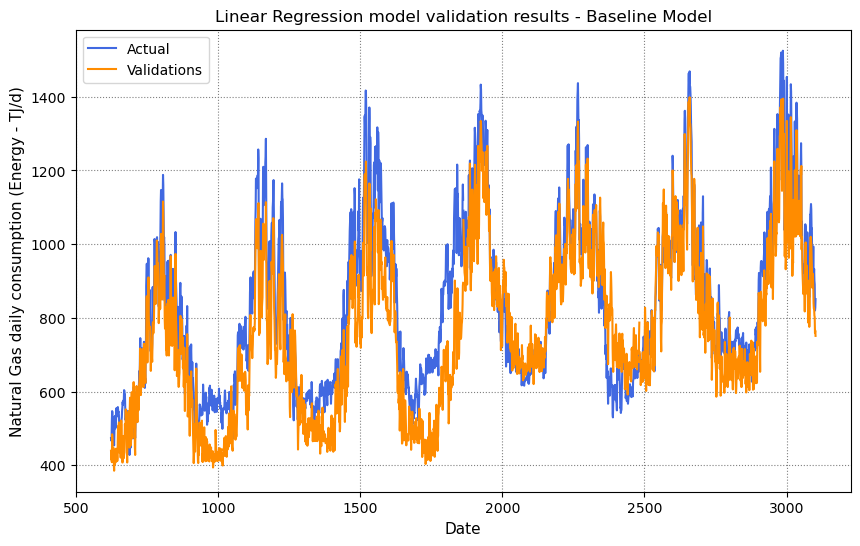


Average Validation Metrics across all Folds:
Mean Squared Error: 12113.538
Mean Absolute Error: 90.061
Root Mean Squared Error: 104.681
Mean Absolute Percentage Error: 11.254%
Median Absolute Percentage Error: 10.350%
R-squared: 0.732


In [11]:
# Split the learning dataset to training and validation sets
learning_df = learning_data_df.copy()

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=4)  # You can adjust the number of splits

# Create a function to calculate evaluation metrics
def calculate_metrics(true_values, predicted_values):
    mse = mean_squared_error(true_values, predicted_values)
    mae = mean_absolute_error(true_values, predicted_values)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100
    mdape = np.median(np.abs((true_values - predicted_values) / true_values)) * 100
    r2 = r2_score(true_values, predicted_values)

    return mse, mae, rmse, mape, mdape, r2

# Create a Linear Regression object
lr = LinearRegression()

# Use the learning_df for training and testing
X = learning_df.drop(['DATE', 'NG_DEMAND'], axis=1)
y = learning_df['NG_DEMAND']

base_metrics = []
plt.figure(figsize=(10, 6))

# Apply Time Series Cross-Validation
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    lr.fit(X_train, y_train)

    # Make predictions on the test set
    validations = lr.predict(X_test)

    # Calculate the mean squared error of the predictions
    mse, mae, rmse, mape, mdape, r2 = calculate_metrics(y_test, validations)
    base_metrics.append((mse, mae, rmse, mape, mdape, r2))

    # Convert the Date to datetime
    learning_df['DATE'] = pd.to_datetime(learning_df['DATE'])

    # Plot actual vs. forecast values
    plt.plot(X_test.index, y_test, label='Actual', color='royalblue')
    plt.plot(X_test.index, validations, label='Validations', color='darkorange')
    
plt.title('Linear Regression model validation results - Baseline Model', fontsize=12)
plt.xlabel('Date', fontsize=11)
plt.ylabel('Natural Gas daily consumption (Energy - TJ/d)', fontsize=11)
# Only add the legend once
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.grid(linestyle=":", color='grey')
plt.show()

avg_baseline_metrics = np.mean(base_metrics, axis=0)
print("\nAverage Validation Metrics across all Folds:")
print(f"Mean Squared Error: {avg_baseline_metrics[0]:.3f}")
print(f"Mean Absolute Error: {avg_baseline_metrics[1]:.3f}")
print(f"Root Mean Squared Error: {avg_baseline_metrics[2]:.3f}")
print(f"Mean Absolute Percentage Error: {avg_baseline_metrics[3]:.3f}%")
print(f"Median Absolute Percentage Error: {avg_baseline_metrics[4]:.3f}%")
print(f"R-squared: {avg_baseline_metrics[5]:.3f}")


## 2. SARIMAX Model 

SARIMAX is a combination of four different modules i.e.
 --> It stands for seasonality. In case if you identify that the data patterns is repeating every month /year then yes it is seasonalit


 -AR-> Auto Regressive means like my current value is dependent on which all lagged values or past val

s -

I-> In case if your dataset is not stationary you keep trying to make it stationary in case of ARIMA model right like we did in the post mentioned above. I stands for number of differentiation we create with the previous existing v

ue - 

MA-> Moving Average and to extent we need to rol

i - p.

X-> It stands for other exogeneous variables which causes the variable to change. It is used while we are doing multi variate time series analysis.

Fold 1 Metrics:
MSE: 10921.423, MAE: 88.818, RMSE: 104.506, MAPE: 11.517%, MdAPE: 12.093%, R-squared: 0.712
Fold 2 Metrics:
MSE: 11864.250, MAE: 90.518, RMSE: 108.923, MAPE: 10.990%, MdAPE: 10.473%, R-squared: 0.754
Fold 3 Metrics:
MSE: 9628.985, MAE: 81.999, RMSE: 98.127, MAPE: 8.899%, MdAPE: 9.398%, R-squared: 0.805
Fold 4 Metrics:
MSE: 17336.310, MAE: 112.392, RMSE: 131.667, MAPE: 11.203%, MdAPE: 11.431%, R-squared: 0.599


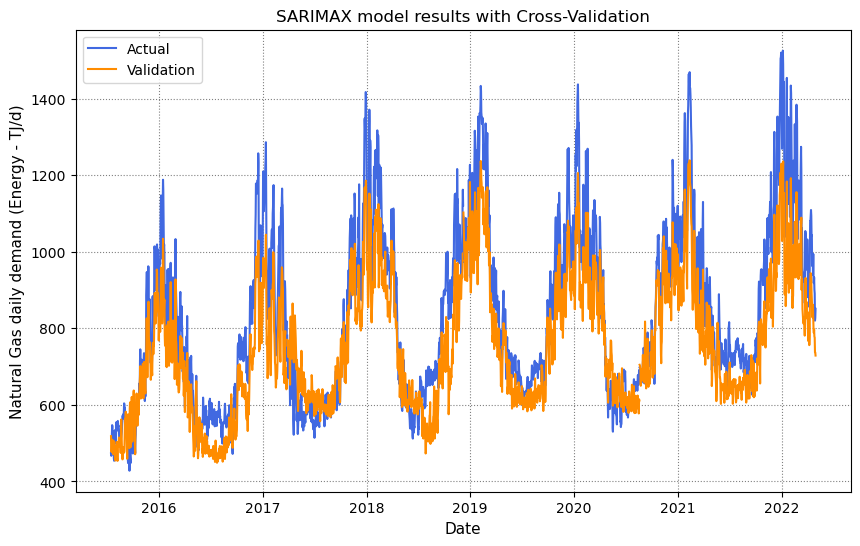


Average Metrics Across All Folds:
Mean Squared Error: 12437.742
Mean Absolute Error: 93.432
Root Mean Squared Error: 110.806
Mean Absolute Percentage Error: 10.653%
Median Absolute Percentage Error: 10.849%
R-squared: 0.718


In [12]:
# Load the dataset and convert the 'DATE' column to a datetime object
data = learning_data_df.copy()
data['DATE'] = pd.to_datetime(data['DATE'])
data.set_index('DATE', inplace=True)

# Define the exogenous variables 
exog_variables = data[['LOWEST_REL_HUMIDITY', 'HIGHEST_REL_HUMIDITY', 'HEATING_DEGREE_DAYS', 'COOLING_DEGREE_DAYS', 'TOTAL_PRECIPITATION', 'LOWEST_TEMPERATURE', 
                       'AVG_TEMPERATURE', 'HIGHEST_TEMPERATURE', 'DIRECTION_MAX_GUST', 'SPEED_MAX_GUST']]

# Create a custom transformer to calculate SARIMAX predictions
class SARIMAXPredictor(BaseEstimator, TransformerMixin):
    def __init__(self, order=(1, 0, 1), seasonal_order=(0, 1, 1, 50)):
        self.order = order
        self.seasonal_order = seasonal_order

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        predictions = []
        tscv = TimeSeriesSplit(n_splits=4)
        fold_metrics = []

        # Create a new figure for the plot
        plt.figure(figsize=(10,6))

        for i, (train_index, test_index) in enumerate(tscv.split(X)):
            train_data = X.iloc[train_index]
            test_data = X.iloc[test_index]

            model = sm.tsa.SARIMAX(train_data['NG_DEMAND'], exog=exog_variables.iloc[train_index], order=self.order, seasonal_order=self.seasonal_order)
            results = model.fit()

            forecast = results.get_forecast(steps=len(test_data), exog=exog_variables.iloc[test_index])
            forecast_mean = forecast.predicted_mean

            # Append the forecasted values to the list
            predictions.append(forecast_mean.values)

            mse, mae, rmse, mape, mdape, r2 = calculate_metrics(test_data['NG_DEMAND'], forecast_mean)
            fold_metrics.append((mse, mae, rmse, mape, mdape, r2))

            # Plot the forecast and test data for this fold
            plt.plot(test_data.index, test_data['NG_DEMAND'], color='royalblue', label='Actual')
            plt.plot(test_data.index, forecast_mean, color='darkorange', label='Validation')

            print(f"Fold {i+1} Metrics:")
            print(f"MSE: {mse:.3f}, MAE: {mae:.3f}, RMSE: {rmse:.3f}, MAPE: {mape:.3f}%, MdAPE: {mdape:.3f}%, R-squared: {r2:.3f}")

        # Show the plot with a legend
        plt.title('SARIMAX model results with Cross-Validation', fontsize=12)
        plt.xlabel('Date', fontsize=11)
        plt.ylabel('Natural Gas daily demand (Energy - TJ/d)', fontsize=11)
        # Only add the legend once
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())
        
        plt.grid(linestyle=":", color='grey')
        plt.show()

        return predictions, fold_metrics

# Create a function to calculate evaluation metrics
def calculate_metrics(true_values, predicted_values):
    mse = mean_squared_error(true_values, predicted_values)
    mae = mean_absolute_error(true_values, predicted_values)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100
    mdape = np.median(np.abs((true_values - predicted_values) / true_values)) * 100
    r2 = r2_score(true_values, predicted_values)

    return mse, mae, rmse, mape, mdape, r2

# Create a pipeline with SARIMAXPredictor and metric calculation
pipeline = Pipeline([
    ('sarimax', SARIMAXPredictor(order=(1, 0, 1), seasonal_order=(0, 1, 1, 7))),
])

# Fit the pipeline to the data
predicted_values, fold_metrics = pipeline.fit_transform(data, data['NG_DEMAND'])

# Calculate and print the average evaluation metrics across all folds
average_metrics = np.mean(fold_metrics, axis=0)
print("\nAverage Metrics Across All Folds:")
print(f"Mean Squared Error: {average_metrics[0]:.3f}")
print(f"Mean Absolute Error: {average_metrics[1]:.3f}")
print(f"Root Mean Squared Error: {average_metrics[2]:.3f}")
print(f"Mean Absolute Percentage Error: {average_metrics[3]:.3f}%")
print(f"Median Absolute Percentage Error: {average_metrics[4]:.3f}%")
print(f"R-squared: {average_metrics[5]:.3f}")

### Hyperparameter Tuning

Fold 1 Metrics:
MSE: 4663.697, MAE: 56.056, RMSE: 68.291, MAPE: 7.952%, MdAPE: 7.004%, R-squared: 0.877
Fold 2 Metrics:
MSE: 7217.288, MAE: 69.574, RMSE: 84.955, MAPE: 8.714%, MdAPE: 8.032%, R-squared: 0.851
Fold 3 Metrics:
MSE: 5343.182, MAE: 56.680, RMSE: 73.097, MAPE: 7.481%, MdAPE: 5.135%, R-squared: 0.892
Fold 4 Metrics:
MSE: 7095.650, MAE: 68.737, RMSE: 84.236, MAPE: 7.007%, MdAPE: 6.794%, R-squared: 0.836


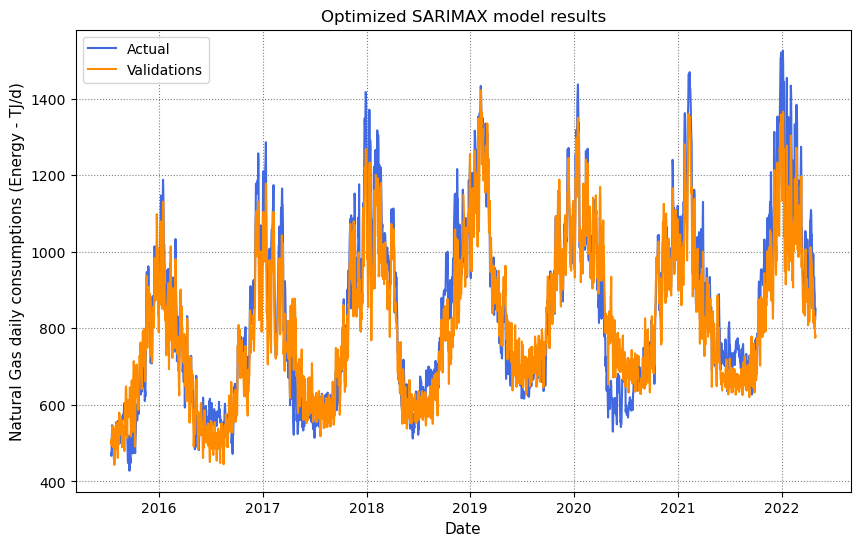


Average Metrics Over the Rolls:
Mean Squared Error: 6079.954
Mean Absolute Error: 62.762
Root Mean Squared Error: 77.645
Mean Absolute Percentage Error: 7.788%
Median Absolute Percentage Error: 6.741%
R-squared: 0.864


In [14]:
# Load the dataset and convert the 'DATE' column to a datetime object
data = learning_data_df.copy()
data['DATE'] = pd.to_datetime(data['DATE'])

# Prepare the features and target
X = data.drop(['DATE', 'NG_DEMAND'], axis=1)
y = data['NG_DEMAND']

# Create a function to calculate evaluation metrics
def compute_metrics(true_values, predicted_values):
    mse = mean_squared_error(true_values, predicted_values)
    mae = mean_absolute_error(true_values, predicted_values)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100
    mdape = np.median(np.abs((true_values - predicted_values) / true_values)) * 100
    r2 = r2_score(true_values, predicted_values)

    return mse, mae, rmse, mape, mdape, r2

class SARIMAXWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)):
        self.order = order
        self.seasonal_order = seasonal_order
        self.model = None

    def fit(self, X, y):
        self.model = SARIMAX(y, exog=X, order=self.order, seasonal_order=self.seasonal_order)
        self.results = self.model.fit(disp=True, maxiter=10)
        return self

    def predict(self, X):
        forecast_steps = X.shape[0]
        return self.results.get_forecast(steps=forecast_steps, exog=X).predicted_mean


# Set up cross-validation
tscv = TimeSeriesSplit(n_splits=4)  # Adjust the number of splits as needed

# Define a pipeline combining feature selection and SARIMAX model
pipe = Pipeline([
    ('select_best', SelectKBest(score_func=f_regression)),
    ('sarimax', SARIMAXWrapper())
])

# Define a smaller grid of hyperparameters
param_grid = {
    'select_best__k': range(1, len(X.columns) + 1),
    'sarimax__order': [(p, d, q) for p in range(2) for d in range(2) for q in range(2)],
    'sarimax__seasonal_order': [(P, D, Q, S) for P in range(2) for D in range(2) for Q in range(2) for S in [12]]
}

# Set up a randomized search with cross-validation
grid = RandomizedSearchCV(pipe, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1, n_iter=100)
grid.fit(X, y)

# Get the best model
best_model = grid.best_estimator_

# Saving the trained model to a file
with open('../models/optimized_sarimax_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

# Unpickle the saved model
with open('../models/optimized_sarimax_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Create a figure before the loop
plt.figure(figsize=(10, 6))

fold_metrics = []

# Perform time series cross-validation with rolling basis using the best model
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit SARIMA model with exogenous variables using the best model
    best_model.fit(X_train, y_train)

    # Forecast future values
    y_pred = best_model.predict(X_test)

    mse, mae, rmse, mape, mdape, r2 = compute_metrics(y_test, y_pred)
    fold_metrics.append((mse, mae, rmse, mape, mdape, r2))
    
    print(f"Fold {i+1} Metrics:")
    print(f"MSE: {mse:.3f}, MAE: {mae:.3f}, RMSE: {rmse:.3f}, MAPE: {mape:.3f}%, MdAPE: {mdape:.3f}%, R-squared: {r2:.3f}")

    # Plot the forecast and actuals
    plt.plot(data.iloc[test_index]['DATE'], y_test, color='royalblue', label='Actual')
    plt.plot(data.iloc[test_index]['DATE'], y_pred, color='darkorange', label='Validations')

# Add title, labels, and legend after the loop
plt.title('Optimized SARIMAX model results', fontsize=12)
plt.xlabel('Date', fontsize=11)
plt.ylabel('Natural Gas daily consumptions (Energy - TJ/d)', fontsize=11)

# Only add the legend once
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.grid(linestyle=":", color='grey')
plt.show()

# Calculate and print the average evaluation metrics across all folds
average_optimized_metrics = np.mean(fold_metrics, axis=0)
print(f'\nAverage Metrics Over the Rolls:')
print(f"Mean Squared Error: {average_optimized_metrics[0]:.3f}")
print(f"Mean Absolute Error: {average_optimized_metrics[1]:.3f}")
print(f"Root Mean Squared Error: {average_optimized_metrics[2]:.3f}")
print(f"Mean Absolute Percentage Error: {average_optimized_metrics[3]:.3f}%")
print(f"Median Absolute Percentage Error: {average_optimized_metrics[4]:.3f}%")
print(f"R-squared: {average_optimized_metrics[5]:.3f}")


## SARIMAX model Validation Performance 

In [16]:
# Accessing individual metrics for Baseline model with cross-validation 
mse_baseline_cv = avg_baseline_metrics[0]
mae_baseline_cv= avg_baseline_metrics[1]
rmse_baseline_cv = avg_baseline_metrics[2]
mape_baseline_cv = avg_baseline_metrics[3]
mdape_baseline_cv = avg_baseline_metrics[4]
r2_baseline_cv = avg_baseline_metrics[5]

# Accessing individual metrics for SARIMAX model with cross-validation 
mse_sarimax_cv = average_metrics[0]
mae_sarimax_cv= average_metrics[1]
rmse_sarimax_cv = average_metrics[2]
mape_sarimax_cv = average_metrics[3]
mdape_sarimax_cv = average_metrics[4]
r2_sarimax_cv = average_metrics[5]

# Accessing individual metrics for Optimized SARIMAX model with cross-validation 
mse_sarimax_hy = average_optimized_metrics[0]
mae_sarimax_hy= average_optimized_metrics[1]
rmse_sarimax_hy = average_optimized_metrics[2]
mape_sarimax_hy = average_optimized_metrics[3]
mdape_sarimax_hy = average_optimized_metrics[4]
r2_sarimax_hy = average_optimized_metrics[5]

# Define the metrics for the model
metrics_baseline_cv = [mse_baseline_cv, rmse_baseline_cv, mape_baseline_cv, mae_baseline_cv, mdape_baseline_cv, r2_baseline_cv]
metrics_sarimax_cv = [mse_sarimax_cv, rmse_sarimax_cv, mape_sarimax_cv, mae_sarimax_cv, mdape_sarimax_cv, r2_sarimax_cv]
metrics_sarimax_hy = [mse_sarimax_hy, rmse_sarimax_hy, mape_sarimax_hy, mae_sarimax_hy, mdape_sarimax_hy, r2_sarimax_hy]

# Define the labels for the metrics
labels = ['MSE', 'RMSE', 'MAPE', 'MAE', 'MDAPE', 'R-squared']

# Create a DataFrame to store the metrics
df_metrics_sarimax = pd.DataFrame({'Baseline Model': metrics_baseline_cv, 'SARIMAX': metrics_sarimax_cv, 
                                'Optimized SARIMAX': metrics_sarimax_hy}, index=labels)

# Transpose the DataFrame
df_metrics_sarimax = df_metrics_sarimax.transpose()

df_metrics_sarimax = df_metrics_sarimax.applymap(lambda x: f'{x: .3}')
df_metrics_sarimax.head(10)

,MSE,RMSE,MAPE,MAE,MDAPE,R-squared
Baseline Model,1.21e+04,1.05e+02,11.3,90.1,10.4,0.732
SARIMAX,1.24e+04,1.11e+02,10.7,93.4,10.8,0.718
Optimized SARIMAX,6.08e+03,77.6,7.79,62.8,6.74,0.864


Here's a summary of the performance of the three models:

- **Baseline Model**: This model has a Mean Squared Error (MSE) of 1.21e+04, Root Mean Squared Error (RMSE) of 1.05e+02, Mean Absolute Percentage Error (MAPE) of 11.3, Mean Absolute Error (MAE) of 90.1, Median Absolute Percentage Error (MDAPE) of 10.4, and an R-squared value of 0.732.

- **SARIMAX Model**: This model has an MSE of 1.24e+04, RMSE of 1.11e+02, MAPE of 10.7, MAE of 93.4, MDAPE of 10.8, and an R-squared value of 0.718.

- **Optimized SARIMAX Model**: This model performs the best among all models, with an MSE of 6.08e+03, RMSE of 77.6, MAPE of 7.79, MAE of 62.8, MDAPE of 6.74, and an R-squared value of 0.864.

In summary, the Optimized SARIMAX model performs the best in terms of all the metrics used for evaluation. It has the lowest MSE, RMSE, MAPE, MAE, and MDAPE, and the highest R-squared value, indicating the best fit to the data. The other models also show improvements over the baseline model, but not as much as the Optimized SARIMAX model.

## SARIMAX Model Prediction Performance 


Prediction Performance Metrics for the Testing Dataset:
Test Mean Absolute Error: 54.007
Test Mean Squared Error: 4256.313
Test Root Mean Squared Error: 65.240
Test R-squared: 0.899
Test Mean Absolute Percentage Error: 6.114%
Test Median Absolute Percentage Error: 5.335%


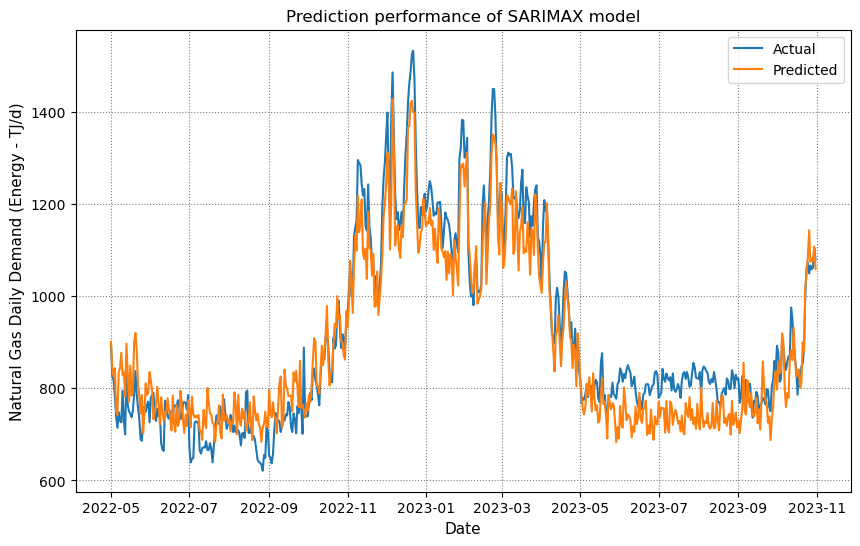

In [18]:
# Import library to load saved model
testing_set_df = testing_data_df.copy()

X_test = testing_set_df.drop(['DATE', 'NG_DEMAND'], axis=1)

# Unpickle the saved model
with open('../models/optimized_sarimax_model.pkl', 'rb') as file:
    load_model = pickle.load(file)

# Predict on the test set
y_pred = load_model.predict(X_test)

# Create a dataframe that contains testing_set_df['DATE'], testing_set_df['NG_DEMAND'], and y_pred
results_df = testing_set_df[['DATE', 'NG_DEMAND']].copy()
results_df['Predicted_NG_DEMAND'] = y_pred

# Calculate performance metrics for the test set
mae_test = mean_absolute_error(testing_set_df['NG_DEMAND'], y_pred)
mse_test = mean_squared_error(testing_set_df['NG_DEMAND'], y_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(testing_set_df['NG_DEMAND'], y_pred)
mape_test = np.mean(np.abs((testing_set_df['NG_DEMAND'] - y_pred) / testing_set_df['NG_DEMAND'])) * 100
mdape_test = np.median(np.abs((testing_set_df['NG_DEMAND'] - y_pred) / testing_set_df['NG_DEMAND'])) * 100

# Print prediction performance metrics
print("\nPrediction Performance Metrics for the Testing Dataset:")
print(f'Test Mean Absolute Error: {mae_test:.3f}')
print(f'Test Mean Squared Error: {mse_test:.3f}')
print(f'Test Root Mean Squared Error: {rmse_test:.3f}')
print(f'Test R-squared: {r2_test:.3f}')
print(f'Test Mean Absolute Percentage Error: {mape_test:.3f}%')
print(f'Test Median Absolute Percentage Error: {mdape_test:.3f}%')

# Convert the Date to datetime
results_df['DATE'] = pd.to_datetime(results_df['DATE'])

# Plotting actuals and forecasted values for the test set
plt.figure(figsize=(10, 6))
plt.plot(results_df['DATE'], results_df['NG_DEMAND'], label='Actual')
plt.plot(results_df['DATE'], results_df['Predicted_NG_DEMAND'], label='Predicted')
plt.legend()
plt.xlabel('Date', fontsize=11)
plt.ylabel('Natural Gas Daily Demand (Energy - TJ/d)', fontsize=11)
plt.grid(linestyle=":", color='grey')
plt.title('Prediction performance of SARIMAX model', fontsize=12)

plt.show()

In [19]:
# Save the prediction result dataframe
results_df.reset_index(drop=True, inplace=True)
results_df.to_csv('../data/sarimax_prediction.csv', index=False)
results_df.head()

,DATE,NG_DEMAND,Predicted_NG_DEMAND
0,2022-05-01,894,900.770210
1,2022-05-02,826,841.161946
2,2022-05-03,818,825.648137
3,2022-05-04,782,843.407415
4,2022-05-05,737,748.287475


In [21]:
# Define the metrics for the predicted model
sarimax_prediction_metrics = [mse_test, rmse_test, mape_test, mae_test, mdape_test, r2_test]

# Define the labels for the metrics
labels = ['MSE', 'RMSE', 'MAPE', 'MAE', 'MDAPE', 'R-squared']

# Create a DataFrame to store the metrics
df_sarimax_pred = pd.DataFrame({'SARIMAX Model Prediction': sarimax_prediction_metrics}, index=labels)

# Transpose the DataFrame
df_sarimax_pred = df_sarimax_pred.transpose()

df_sarimax_pred = df_sarimax_pred.applymap(lambda x: f'{x: .3}')

# Save the DataFrame to a CSV file
df_sarimax_pred.to_csv('../data/sarimax_predictions_metrics.csv', index=False)
df_sarimax_pred.head(10)

,MSE,RMSE,MAPE,MAE,MDAPE,R-squared
SARIMAX Model Prediction,4.26e+03,65.2,6.11,54.0,5.33,0.899


The performance of the Optimized SARIMAX model on the testing dataset is summarized as follows:

- **Mean Squared Error (MSE): 4.26e+03** - This is the average of the squares of the differences between the actual and predicted values. A lower MSE indicates a better fit of the model to the data. In this case, the MSE is relatively low, suggesting a good fit.

- **Root Mean Squared Error (RMSE): 65.2** - This is the square root of the MSE. It measures the standard deviation of the residuals. A lower RMSE indicates a better fit of the model. The RMSE for this model is relatively low, suggesting a good fit.

- **Mean Absolute Percentage Error (MAPE): 6.11%** - This is the average of the absolute percentage differences between the actual and predicted values. A lower MAPE indicates a better fit of the model. The MAPE for this model is relatively low, indicating good predictive performance.

- **Mean Absolute Error (MAE): 54.0** - This is the average of the absolute differences between the actual and predicted values. A lower MAE indicates a better fit of the model. The MAE for this model is relatively low, indicating good predictive performance.

- **Median Absolute Percentage Error (MDAPE): 5.33%** - This is the median of the absolute percentage differences between the actual and predicted values. A lower MDAPE indicates a better fit of the model. The MDAPE for this model is relatively low, indicating good predictive performance.

- **R-squared: 0.899** - This is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model. An R-squared of 0.899 indicates that 89.9% of the data fit the regression model.

In summary, the Optimized SARIMAX model shows strong performance on the testing dataset across all metrics. It has a high R-squared value and relatively low error metrics (MSE, RMSE, MAPE, MAE, MDAPE), indicating a good fit to the data and strong predictive performance.